IMPORT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import concatenate, Reshape, Input, Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM,MaxPooling1D, Activation,GlobalMaxPooling1D, UpSampling1D
from keras.losses import MAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import keras.backend as K
import random as random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
# from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# LIGHT

Переписал функции руками, внеся небольшие изменения:
- добавлены слои батчнормализация и дропаут с веротяностями 50% появления
- размер дропаута тоже регуляируется вероятностью


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving traff (1).csv to traff (1) (1).csv


In [ ]:
base_data = pd.read_csv('/content/traff (1).csv', header=None)

In [ ]:
base_data = pd.read_csv('Documents/ДЗ/29/traff.csv', header=None)   # для загрузки из локальной среды
base_data.head(5)

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"


In [ ]:
base_data.shape

(1095, 2)

In [ ]:
data = base_data.iloc[:,1]

In [ ]:
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

Функция загрузки данных

In [ ]:
xLen = 60
valLen = 300

trainLen = data.shape[0] - valLen

Train, Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1,
                                   batch_size=20)
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1,
                                   batch_size=20)

Функция для отображения результатов

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], label = 'Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

def correlate(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab - ma*mb)/(sa*sb)
  return val

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=Flatten):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:,ch]))

    own_corr = []

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:,ch]))

    if showGraf:
      plt.plot(corr, label = 'предсказание на '+ str(ch+1) + 'шаг')
      plt.plot(own_corr, label = 'Эталон')
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData:
    return corr, own_corr
    

Генерируем проверочную выборку

In [ ]:
DataGen = TimeseriesGenerator(Test, Test, 
                              length=xLen, sampling_rate=1,
                              batch_size=len(Test))

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0


**Первый скрытый слой**

*   6 - Делаем ли второй сверточный слой
*   7 - делаем ли нормализацию
*   8 - делаем ли Дропаут
*   9 - размер дропаута
*   10 - размер второго сверточного слоя
*   11 - ядро второго сверточного слоя
*   12 - делаем ли MaxPooling1
*   13 - размер MaxPooling1
*   14 - функция активации

**Второй скрытый слой**

*   15 - Делаем ли третий сверточный слой
*   16 - делаем ли нормализацию
*   17 - делаем ли Дропаут
*   18 - размер дропаута
*   19 - размер третьего сверточного слоя
*   20 - ядро третьего сверточного слоя
*   21 - делаем ли MaxPooling2
*   22 - размер MaxPooling2
*   23 - функция активации 
----
*   24 - функция активации предпоследнего слоя
*   25 - функция активации выходного слоя
----
**Третий(предпоследний) скрытый слой**

*   26 - делаем ли нормализацию 
*   27 - размер полносвязного слоя

In [ ]:
def createConvNet(net):

  model = Sequential()

  makeFirstNormalization = net[0]
  firstConvSize = 2 ** net[1]
  firstConvKernel = net[2]
  activation0 = net[3]
  makeMaxPooling0 = net[4]
  maxPoolingSize0 = net[5]

  makeSecondConv = net[6]
  makeNormalization_1 = net[7]
  makeDropout_1 = net[8]
  dropoutSize_1 = net[9]
  secondConvSize = 2 ** net[10]
  secondConvKernel = net[11]
  makeMaxPooling1 = net[12]
  maxPoolingSize1 = net[13]
  activation1 = net[14]

  makeThirdConv = net[15]
  makeNormalization_2 = net[16]
  makeDropout_2 = net[17]
  dropoutSize_2 = net[18]
  thirdConvSize = 2 ** net[19]
  thirdConvKernel = net[20]
  makeMaxPooling2 = net[21]
  maxPoolingSize2 = net[22]
  activation2 = net[23]

  activation3 = net[24]
  activation4 = net[25]

  makeSecondNormalization = net[26]
  denseSize = 2 ** net[27] 

  activation_list = ['linear','relu','tanh','softmax','sigmoid']
  dropout_list = [0.2, 0.4, 0.5, 0.6, 0.8]

  if (makeFirstNormalization):
    model.add(BatchNormalization(input_shape=(xLen, 1))) 
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0:
    model.add(MaxPooling1D(maxPoolingSize0))

  if (makeSecondConv):
    if makeNormalization_1:
      model.add(BatchNormalization())
    if makeDropout_1:
      model.add(Dropout(dropout_list[dropoutSize_1]))
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):
      model.add(MaxPooling1D(pool_size=maxPoolingSize1))

  if (makeThirdConv):
    if makeNormalization_2:
      model.add(BatchNormalization())
    if makeDropout_2:
      print(dropoutSize_2)
      model.add(Dropout(dropout_list[dropoutSize_2]))
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

  if (makeSecondNormalization):
    model.add(BatchNormalization())

  model.add(Flatten())
  
  model.add(Dense(denseSize, activation=activation_list[activation3]))
  model.add(Dense(1, activation=activation_list[activation4]))

  return model


def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net)

  model.compile(optimizer=Adam(lr=1e-4), loss='mse')

  history = model.fit_generator(trainDataGen, 
                                epochs=5,
                                verbose=verb,
                                validation_data=testDataGen)
  val = history.history['val_loss'][-1]

  return val, model

def createRandomNet():
  net = []
  net.append(random.randint(0,1))  #0
  net.append(random.randint(3,6)) #1
  net.append(random.randint(3,7)) #2
  net.append(random.randint(0,4)) #3
  net.append(random.randint(0,1)) #4
  net.append(random.randint(2,5)) #5

  net.append(random.randint(0,1)) #6
  net.append(random.randint(0,1)) #7
  net.append(random.randint(0,1)) #8 
  net.append(random.randint(0,4)) #9
  net.append(random.randint(3,6)) #10
  net.append(random.randint(3,7)) #11
  net.append(random.randint(0,1)) #12
  net.append(random.randint(2,5)) #13
  net.append(random.randint(0,4)) #14

  net.append(random.randint(0,1)) #15
  net.append(random.randint(0,1)) #16
  net.append(random.randint(0,1)) #17 
  net.append(random.randint(0,4)) #18
  net.append(random.randint(3,6)) #19
  net.append(random.randint(3,7)) #20
  net.append(random.randint(0,1)) #21
  net.append(random.randint(2,5)) #22
  net.append(random.randint(0,4)) #23

  net.append(random.randint(0,4)) #24
  net.append(random.randint(0,2)) #25

  net.append(random.randint(0,1)) #26
  net.append(random.randint(3,6)) #27
  
  return net


In [ ]:
dropout_list = [0.2, 0.4, 0.5, 0.6, 0.8]

In [ ]:
len(dropout_list)

5

In [ ]:
n = 20
nsurv = 10
nnew = n - nsurv
l = 28
epoch = 10

mut = 0.09

popul = []
val = []

for i in range(n):
  popul.append(createRandomNet())

for it in range(epoch):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f, model_sum = evaluateNet(bot, 3, 0)
    val.append(f)

  sval  = sorted(val, reverse=0)
  print(it, time.time()-curr_time, ' ', sval[0:5], popul[:5])

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])

  for i in range(nnew):
    indexp1 = random.randint(0, nsurv-1)
    indexp2 = random.randint(0, nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut = createRandomNet()
    for j in range(l):
      x = 0
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      if (random.random() < mut):
        x = net4Mut[j]

      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

C:\Users\Vlaso\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


4
1
2
4
2
0 72.0923798084259   [0.00844592321664095, 0.0618613176047802, 0.07149923592805862, 0.07219051569700241, 0.0840112641453743] [[0, 5, 5, 2, 0, 3, 1, 1, 1, 4, 6, 5, 1, 5, 4, 1, 1, 0, 1, 6, 7, 1, 2, 1, 3, 0, 1, 5], [1, 3, 6, 4, 0, 2, 1, 1, 1, 2, 3, 7, 1, 5, 1, 0, 0, 1, 4, 6, 4, 0, 4, 2, 2, 2, 0, 5], [0, 4, 6, 2, 0, 2, 1, 1, 1, 1, 4, 6, 1, 3, 2, 0, 0, 1, 1, 5, 5, 0, 3, 1, 3, 0, 0, 6], [1, 6, 3, 3, 0, 4, 0, 1, 0, 2, 6, 4, 1, 3, 4, 0, 0, 0, 1, 4, 5, 1, 2, 4, 4, 0, 1, 6], [1, 5, 3, 2, 1, 3, 1, 1, 1, 1, 5, 3, 1, 5, 4, 1, 1, 0, 1, 5, 6, 0, 5, 3, 0, 0, 0, 6]]
2
2
4
2
0
1 46.6195023059845   [0.008055802434682846, 0.024561431258916855, 0.06727404147386551, 0.06800618022680283, 0.07256659120321274] [[0, 4, 7, 1, 0, 5, 0, 1, 0, 0, 4, 6, 0, 3, 2, 0, 0, 1, 3, 4, 6, 1, 5, 3, 0, 0, 0, 6], [1, 5, 5, 0, 1, 3, 1, 0, 1, 2, 5, 5, 1, 2, 2, 1, 1, 1, 2, 5, 7, 0, 3, 0, 0, 1, 1, 5], [1, 3, 6, 4, 0, 2, 1, 1, 1, 2, 3, 7, 1, 5, 1, 0, 0, 1, 4, 6, 4, 0, 4, 2, 2, 2, 0, 5], [0, 5, 5, 1, 1, 4, 1, 0, 1, 0, 4, 5,

In [ ]:
model = createConvNet(popul[0])
model.summary()

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_310 (Conv1D)          (None, 60, 16)            96        
_________________________________________________________________
flatten_200 (Flatten)        (None, 960)               0         
_________________________________________________________________
dense_400 (Dense)            (None, 64)                61504     
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 65        
Total params: 61,665
Trainable params: 61,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=70, 
                    validation_data=testDataGen)

Epoch 1/70
37/37 [==============================] - 1s 7ms/step - loss: 0.1448 - val_loss: 0.0296
Epoch 2/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0270
Epoch 3/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0269
Epoch 4/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0221
Epoch 5/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0256
Epoch 6/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0150
Epoch 7/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0136
Epoch 8/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 9/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0082
Epoch 10/70
37/37 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 11/70
37/37 [

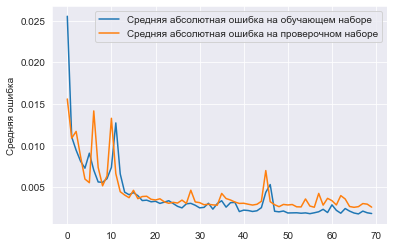

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
def showPredict1(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(14,7))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

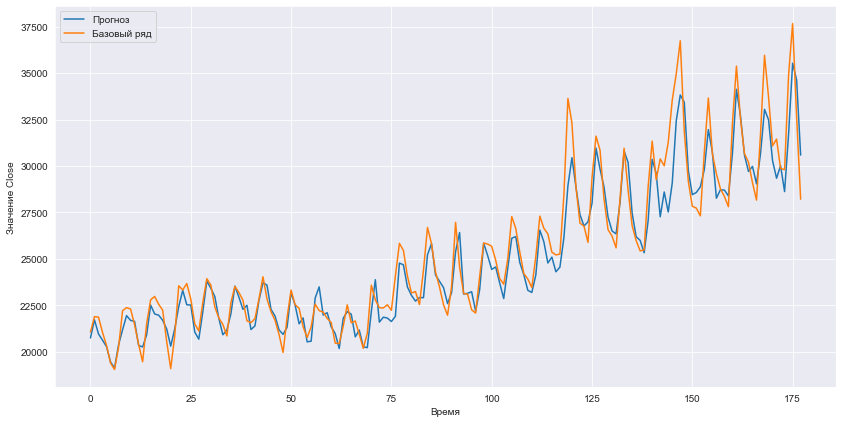

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)

showPredict1(0, 400, 0, predVal, yValUnscaled)

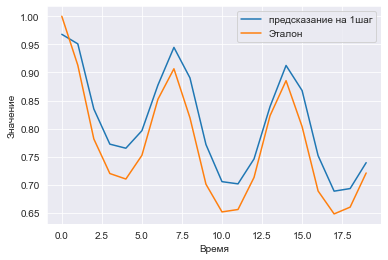

([0.9678898165254551,
  0.9508999368352999,
  0.8350885546558271,
  0.7725430620125103,
  0.7652878254143195,
  0.7964430998707865,
  0.8775017174849207,
  0.9446025314518931,
  0.8904217106189799,
  0.7718410198069987,
  0.7058466265602457,
  0.7019344814875049,
  0.7462488629942535,
  0.8393868514464107,
  0.9124422141193443,
  0.8678883973201337,
  0.7520843019160832,
  0.6889501159074428,
  0.6935695687816179,
  0.7396108221489154],
 [1.0000000000000042,
  0.9128586787071123,
  0.78180127149409,
  0.7202988869131627,
  0.7105186078623946,
  0.7525903199684922,
  0.8522596793815091,
  0.9065995595190239,
  0.8194556089631903,
  0.7012729374860172,
  0.6520459911688907,
  0.6563328804081381,
  0.7133323338545752,
  0.8231480968424711,
  0.8854333255994297,
  0.8038029035139976,
  0.6892480189573705,
  0.6484755473614909,
  0.6605355850395589,
  0.721279121513676])

In [ ]:
autoCorr([0], 20, predVal, yValUnscaled)

# PRO

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving traff.csv to traff.csv


In [ ]:
base_data = pd.read_csv('/content/traff.csv', header=None)

In [ ]:
base_data = pd.read_csv('Documents/ДЗ/29/traff.csv', header=None)    # для загрузки с локальной среды
base_data.head(5)

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"


In [ ]:
base_data.shape

(1095, 2)

In [ ]:
data = base_data.iloc[:,1]

In [ ]:
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

Функция загрузки данных

In [ ]:
xLen = 60
valLen = 300

trainLen = data.shape[0] - valLen

Train, Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1,
                                   batch_size=20)
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1,
                                   batch_size=20)

Функция для отображения результатов

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], label = 'Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

def correlate(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab - ma*mb)/(sa*sb)
  return val

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=Flatten):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:,ch]))

    own_corr = []

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:,ch]))

    if showGraf:
      plt.plot(corr, label = 'предсказание на '+ str(ch+1) + 'шаг')
      plt.plot(own_corr, label = 'Эталон')
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData:
    return corr, own_corr
    

In [ ]:
!python --version


Python 3.6.9


Генерируем проверочную выборку

In [ ]:
DataGen = TimeseriesGenerator(Test, Test, 
                              length=xLen, sampling_rate=1,
                              batch_size=len(Test))

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

** Блоки с разными количествами слоев и разным количеством ветвей***

 Ветви и слои выбираются ГА. Максимальное количество ветвей и слоев задаются переменными tree_n и layer_n. Минимальное количетво ветвей и слоев в ней я ограничил 2мя.
 Внутри каждой ветви ГА выбирает сколько количество слоев будет добавлено в кажую конкретную ветвь и определяет слои, выбирая из списка Conv1D, Dropout, BatchNormalization, MaxPooling1D - вероятность каждого слоя - 25%.
 В конце каждой ветви данный вытягиваются флэттеном для последующей конкатенации


 ** Блок с денс слоями**

 ГА подбирает какое количество денс слоев необходимо добавить в конце, перед финальным слоем. Количество может быть выбрано от 1 до максимум, заданного переменной dense_n. Кроме количества ГА подбирает и количество нейронов с функцией акцивации

 **Финальный слой**
 Полносвязный слой с одним нейроном. ГА подбирает функцию акцтивации


 Решил сделать сеть, в которой будет рассчитываться максимаьный размер всех параметров исходя и заданных tree_n, layer_n, dense_n. Весь размер сети изначально заполняется -1 (минус 1). При определении фактического количества ветвей и слоев, фактические значения заполняются подобранными ГА параметрами, а разница между фактом и максимумом по количеству так и остается с минус единицами и игнорируется при дальнейшем построении модели.

 Каждый слой во втором блоке занимает три параметрав net:
 - свертка: ядро, размер окна, активация
 - дропаут: размер, игнорируется, игноируется
 - батчнормализация: игнорируется, игнорируется, игнорируется (параметры не заполняются)
 - макспулинг: размер окна пулинга

 Каждый полносвязный слой занимает 2 параметра в net:
 - количество нейронов
 - функция активации

 

In [ ]:

def createRandomNet(tree_n=10, layer_n=10, dense_n=10):
  layer_list = ['Conv1D','Dropout', 'BatchNormalization', 'MaxPooling1D']
  net_size = 6 + tree_n * layer_n * 4 + dense_n * 2 + 1     # максимальный размер сети по заданным параметрам
  net = [-1 for i in range(net_size)]
  net[0] = random.randint(0,1)  #0 makeFirstNormalization
  net[1] = random.randint(3,6) #1 firstConvSize
  net[2] = random.randint(3,7) #2 firstConvKernel
  net[3] = random.randint(0,4) #3 activation0
  net[4] = random.randint(0,1) #4 makeMaxPooling0
  net[5] = random.randint(2,5) #5 maxPoolingSize0

  tree = random.randint(2,tree_n)  # количество ветвей сети
  for vetv in range(tree):
    lay_number = random.randint(2,layer_n)  # количестов слоев в ветви
    for lay in range(lay_number):
      max_prob = random.randint(0,3) 

      net[6+vetv*layer_n*4+lay*4] = max_prob           # индекс добавляемого слоя

      if max_prob == 0:                    # конв1д
        net[6+vetv*layer_n*4+lay*4+1] = random.randint(3,10)  # размер сверточного слоя
        net[6+vetv*layer_n*4+lay*4+2] = random.randint(3,7)   # ядро сверточного слоя
        net[6+vetv*layer_n*4+lay*4+3] = random.randint(0,4)   # функция активации

      if max_prob == 1:                  # dropout
        net[6+vetv*layer_n*4+lay*4+1] = random.randint(0,4) #размер дропаута

      if max_prob == 3:                  #maxpooling
        net[6+vetv*layer_n*4+lay*4+1] = random.randint(2,4) #размер макспулинга

  dense_numbers = random.randint(1, dense_n)   # количество денс слоев
  for dens in range(dense_numbers):
    net[6 + tree_n * layer_n * 4 + dens*2] = random.randint(3,10)
    net[6 + tree_n * layer_n * 4 + dens*2 + 1] = random.randint(0,4)

  net[-1] = random.randint(0,4)  # функция активации последнего слоя

  return net, net_size


In [ ]:
def createConvNet(net, tree_n=10, layer_n=10, dense_n=10):

# первый входной блок
  makeFirstNormalization = net[0]
  firstConvSize = 2 ** net[1]
  firstConvKernel = net[2]
  activation0 = net[3]
  makeMaxPooling0 = net[4]
  maxPoolingSize0 = net[5]

  activation_list = ['linear','relu','tanh','softmax','sigmoid']
  dropout_list = [0.2, 0.4, 0.5, 0.6, 0.8]
  layer_list = ['Conv1D','Dropout', 'BatchNormalization', 'MaxPooling1D']

  shape = (xLen, 1)
  inputs = Input(shape)
  inputs2 = Flatten()(inputs)

  if (makeFirstNormalization):
    x = BatchNormalization(input_shape=(xLen, 1))(inputs)
    x = Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')(x) 
  else:
    x = Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')(inputs)

  if makeMaxPooling0:
    x = MaxPooling1D(maxPoolingSize0)(x)
  list_to_concat = []
  list_to_concat.append(inputs2)

# блок с подбором разного количества ветвей и слоев
  for vetv in range(tree_n):
    for lay in range(layer_n):
      val = net[6 + vetv*layer_n*4+lay*4]  # каждый 4ый параметр в списке второго блока - указывает на вид слоя
      
      if val != -1 and layer_list[val] == 'Conv1D':
        val_1 = net[6 + vetv*layer_n*4+lay*4 +1]   # ядро
        val_2 = net[6 + vetv*layer_n*4+lay*4 +2]    # размер окна
        val_3 = net[6 + vetv*layer_n*4+lay*4 +3]    # активация

        if lay == 0:        # проверяем первый ли это слой в ветке или нет, для того чобы получить вход либо от первого блока, либо от последнего слоя ветви
          y = Conv1D(2**(val_1), val_2, activation=activation_list[val_3], padding='same')(x)
        else:
          y = Conv1D(2**(val_1), val_2, activation=activation_list[val_3], padding='same')(y)

      elif val != -1 and layer_list[val] == 'Dropout':
        if lay == 0:
          y = Dropout(dropout_list[net[6 + vetv*layer_n*4+lay*4 +1]])(x)   # размер дропаута
        else:
          y = Dropout(dropout_list[net[6 + vetv*layer_n*4+lay*4 +1]])(y)

      elif val != -1 and layer_list[val] == 'BatchNormalization':
        if lay == 0:
          y = BatchNormalization()(x)    
        else:
          y = BatchNormalization()(y)
      
      elif val != -1 and layer_list[val] == 'MaxPooling1D':
        if lay == 0:
          y = MaxPooling1D(net[6 + vetv*layer_n*4+lay*4 +1], padding='same')(x)
        else:
          y = MaxPooling1D(net[6 + vetv*layer_n*4+lay*4 +1], padding='same')(y)
      else:
        break

    y = Flatten()(y)   # вытягиваем выходы всех ветвей для конкатенации
    list_to_concat.append(y)

  fin = concatenate(list_to_concat)   #  объеиняем выход с блоков

  for dens in range(dense_n):
    val = net[6 + tree_n*layer_n*4 + dens*2]   #  количество нейронов в полносвязном слое
    if val != -1:
      fin = Dense(2 ** val, activation=activation_list[net[6 + tree_n*layer_n*4 + dens*2+1]])(fin)

  fin = Dense(1, activation=activation_list[net[-1]])(fin)

  model = Model(inputs, fin)
  return model


def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net, tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)

  model.compile(optimizer=Adam(lr=1e-4), loss='mse')

  history = model.fit_generator(trainDataGen, 
                                epochs=20,
                                verbose=verb,
                                validation_data=testDataGen)

  val = min(history.history["val_loss"])
  return val, model



In [ ]:
import warnings
warnings.filterwarnings('ignore')

tree_n=5
layer_n=5
dense_n=5

n = 20
nsurv = 10
nnew = n - nsurv
epoch = 10

mut = 0.09

popul = []
val = []

for i in range(n):
  net, net_size = createRandomNet(tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)

  popul.append(net)

for it in range(epoch):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f, model_sum = evaluateNet(bot, 3, 0)
    val.append(f)

  sval  = sorted(val, reverse=0)
  print(it, time.time()-curr_time, ' ', sval[0:5], popul[:5])

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])

  for i in range(nnew):
    indexp1 = random.randint(0, nsurv-1)
    indexp2 = random.randint(0, nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut, net_size  = createRandomNet(tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)

    for j in range(6):
      x = 0
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      if (random.random() < mut):
        x = net4Mut[j]
      newbot.append(x)

    for j in range(6, 6+tree_n*layer_n*4, 4):
      x = []
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j:j+4]
      else:
        x = botp2[j:j+4]

      if (random.random() < mut):
        x = net4Mut[j:j+4]
      for i in x:
        newbot.append(i)

    for j in range(6+tree_n*layer_n*4, 6+tree_n*layer_n*4+dense_n*2, 2):
      x = []
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j:j+2]
      else:
        x = botp2[j:j+2]

      if (random.random() < mut):
        x = net4Mut[j:j+2]
      for i in x:
        newbot.append(i)


    pindex = random.random()

    if pindex < 0.5:
      x = botp1[-1]
    else:
      x = botp2[-1]
    if (random.random() < mut):
      x = net4Mut[-1]
    newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

0 217.99766492843628   [0.01213751919567585, 0.015218991786241531, 0.01648671366274357, 0.017318760976195335, 0.017833733931183815] [[1, 5, 5, 2, 1, 3, 2, -1, -1, -1, 3, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 1, 1, -1, -1, 2, -1, -1, -1, 3, 2, -1, -1, 1, 2, -1, -1, 2, -1, -1, -1, 2, -1, -1, -1, 0, 7, 3, 2, 3, 3, -1, -1, 2, -1, -1, -1, 3, 3, -1, -1, 0, 4, 7, 0, 2, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 2, -1, -1, 3, 4, -1, -1, 1, 4, -1, -1, 3, 4, -1, -1, 1, 0, -1, -1, 10, 4, 10, 0, -1, -1, -1, -1, -1, -1, 0], [0, 5, 7, 3, 1, 3, 2, -1, -1, -1, 3, 3, -1, -1, 3, 4, -1, -1, 1, 4, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 0, 6, 4, 2, 3, 4, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, 3, 3, -1, -1, 0, 6, 6, 2, 0, 6, 7, 3, 1, 1, -1, -1, 1, 3, -1, -1, 0, 5, 3, 2, 1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 1, 10, 3, 3, 4, -1, -1, -1, -1, 4], [0, 4, 3, 1, 0, 4, 3, 

In [ ]:
model = createConvNet(popul[0], tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)
model.summary()

Model: "model_200"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_201 (InputLayer)          [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization_744 (BatchN (None, 60, 1)        4           input_201[0][0]                  
__________________________________________________________________________________________________
conv1d_875 (Conv1D)             (None, 60, 16)       112         batch_normalization_744[0][0]    
__________________________________________________________________________________________________
max_pooling1d_786 (MaxPooling1D (None, 20, 16)       0           conv1d_875[0][0]                 
__________________________________________________________________________________________

In [ ]:
# from keras.models import load_model
# model = load_model('Documents/ДЗ/29/model_fin.h5')

In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=30, 
                    validation_data=testDataGen)

Epoch 1/30
37/37 [==============================] - 1s 15ms/step - loss: 0.4225 - val_loss: 0.0639
Epoch 2/30
37/37 [==============================] - 0s 11ms/step - loss: 0.1677 - val_loss: 0.0833
Epoch 3/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0425 - val_loss: 0.0696
Epoch 4/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0429
Epoch 5/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0128 - val_loss: 0.0348
Epoch 6/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 7/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 8/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 9/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0161 - val_loss: 0.0246
Epoch 10/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0165 - val_loss: 0.0244
Epoch 11/

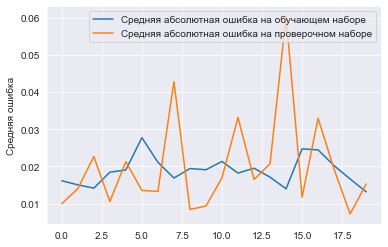

In [ ]:
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

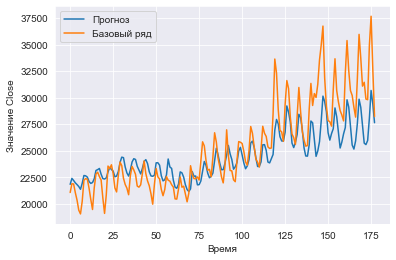

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные
 
# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

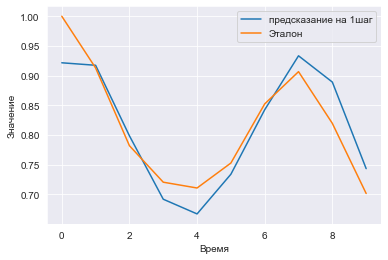

([0.9215556678763638,
  0.9173507072388172,
  0.7984803281950422,
  0.6916065673691394,
  0.6668322451780476,
  0.7336982222199602,
  0.8424021997538604,
  0.9333247613129017,
  0.8890370732407183,
  0.7431689326367794],
 [1.0000000000000042,
  0.9128586787071123,
  0.78180127149409,
  0.7202988869131627,
  0.7105186078623946,
  0.7525903199684922,
  0.8522596793815091,
  0.9065995595190239,
  0.8194556089631903,
  0.7012729374860172])

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)

Итог: mse на проверочной выборке порядка 0.0040

Построим сеть руками:

In [ ]:
def createManualNet():

  shape = (xLen, 1)
  inputs = Input(shape)
  inputs2 = Flatten()(inputs)

# первый блок
  # x1 = BatchNormalization()(inputs)
  x1 = Conv1D(2**8, 5, activation='relu', padding='same')(inputs) 
  x1 = Conv1D(2**8, 5, activation='relu', padding='same')(x1) 
  x1 = MaxPooling1D()(x1)

  # x1 = BatchNormalization())(x1)
  x1 = Conv1D(2**8, 5, activation='relu', padding='same')(x1) 
  x1 = Conv1D(2**8, 5, activation='relu', padding='same')(x1) 
  x1 = MaxPooling1D()(x1)
  x1 = Flatten()(x1)

# второй блок
  # x2 = BatchNormalization()(inputs)
  x2 = Conv1D(2**4, 5, activation='relu', padding='same')(inputs) 
  x2 = Conv1D(2**4, 5, activation='relu', padding='same')(x2) 
  x2 = MaxPooling1D()(x2)

  # x2 = BatchNormalization())(x2)
  x2 = Conv1D(2**4, 5, activation='relu', padding='same')(x2) 
  x2 = Conv1D(2**4, 5, activation='relu', padding='same')(x2) 
  x2 = MaxPooling1D()(x2)
  x2 = Flatten()(x2)


# третий блок
  # x3 = BatchNormalization()(inputs)
  x3 = Conv1D(2**6, 5, activation='relu', padding='same')(inputs) 
  x3 = Conv1D(2**6, 5, activation='relu', padding='same')(x3) 
  x3 = MaxPooling1D()(x3)

  # x3 = BatchNormalization())(x3)
  x3 = Conv1D(2**6, 5, activation='relu', padding='same')(x3) 
  x3 = Conv1D(2**6, 5, activation='relu', padding='same')(x3) 
  x3 = MaxPooling1D(4)(x3)
  x3 = Flatten()(x3)

# четвертый блок
  # x3 = BatchNormalization()(inputs)
  x4 = LSTM(100, return_sequences=True)(inputs) 
  x4 = LSTM(100, return_sequences=True)(x4) 
  x4 = Conv1D(2**6, 5, activation='relu', padding='same')(x4) 
  x4 = MaxPooling1D()(x4)
  x4 = Flatten()(x4)


  fin = concatenate([x1,x2,x3,x4,inputs2])

  fin = Dense(512, activation='relu')(fin)
  fin = Dense(256, activation='relu')(fin)
  fin = Dense(128, activation='relu')(fin)

  fin = Dense(1, activation='tanh')(fin)


  # else:
  #   x = Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')(inputs)

  model = Model(inputs, fin)
  return model



In [ ]:
modelM = createManualNet()

In [ ]:

#Комипилируем и обучаем
modelM.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = modelM.fit_generator(trainDataGen,
                    epochs=100, 
                    validation_data=testDataGen)

Epoch 1/100
37/37 [==============================] - 15s 67ms/step - loss: 0.0424 - val_loss: 0.0169
Epoch 2/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0102 - val_loss: 0.0192
Epoch 3/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0093 - val_loss: 0.0137
Epoch 4/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0077 - val_loss: 0.0220
Epoch 5/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0063 - val_loss: 0.0109
Epoch 6/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0063 - val_loss: 0.0107
Epoch 7/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0042 - val_loss: 0.0095
Epoch 8/100
37/37 [==============================] - 1s 26ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 9/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 10/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0036 - val_loss: 0.006

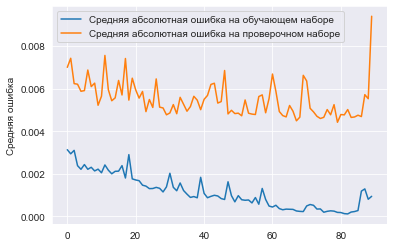

In [ ]:
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:

# Дообучим модель
modelM.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = modelM.fit_generator(trainDataGen,
                    epochs=100, 
                    validation_data=testDataGen)

Epoch 1/100
37/37 [==============================] - 5s 46ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 2/100
37/37 [==============================] - 1s 25ms/step - loss: 3.4163e-04 - val_loss: 0.0044
Epoch 3/100
37/37 [==============================] - 1s 25ms/step - loss: 2.6136e-04 - val_loss: 0.0061
Epoch 4/100
37/37 [==============================] - 1s 24ms/step - loss: 3.1996e-04 - val_loss: 0.0058
Epoch 5/100
37/37 [==============================] - 1s 24ms/step - loss: 3.1400e-04 - val_loss: 0.0092
Epoch 6/100
37/37 [==============================] - 1s 24ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 7/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 8/100
37/37 [==============================] - 1s 24ms/step - loss: 4.3763e-04 - val_loss: 0.0047
Epoch 9/100
37/37 [==============================] - 1s 26ms/step - loss: 1.9300e-04 - val_loss: 0.0055
Epoch 10/100
37/37 [==============================] - 1s 25ms/step - loss: 3

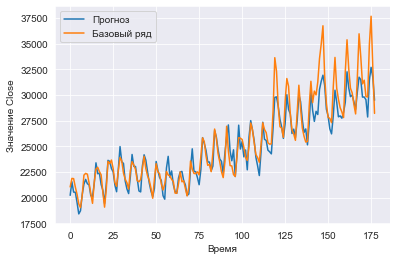

In [ ]:
# Прогнозируем данные текущей сетью
currModel = modelM #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные
 
# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

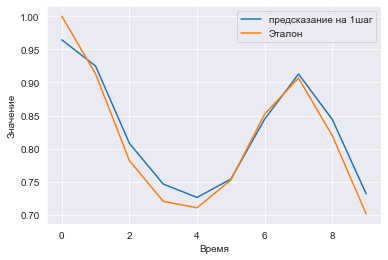

([0.9643755275164011,
  0.924699770936987,
  0.8079093465258993,
  0.7463862369988432,
  0.7261899497085513,
  0.7539817245102366,
  0.8446311241619282,
  0.9127050320100218,
  0.844029983067433,
  0.7316610996030696],
 [1.0000000000000042,
  0.9128586787071123,
  0.78180127149409,
  0.7202988869131627,
  0.7105186078623946,
  0.7525903199684922,
  0.8522596793815091,
  0.9065995595190239,
  0.8194556089631903,
  0.7012729374860172])

In [ ]:
autoCorr([0], 10, predVal, yValUnscaled)

Лучшее значение mse на ручной модели оказалось примерно таким же, как и на подобранной ГА модели.

Чтобы добиться лучших резульататов модели ГА, я увеличил количество маскимальныйх ветвей и слоев в ветви и запустил на 100 эпох (благо времени на данной ДЗ было больше за счет праздников, что позволило запустить расчет надолго)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

tree_n=10
layer_n=10
dense_n=10

n = 20
nsurv = 10
nnew = n - nsurv
epoch = 100

mut = 0.09

popul = []
val = []

for i in range(n):
  net, net_size = createRandomNet(tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)


  popul.append(net)

for it in range(epoch):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f, model_sum = evaluateNet(bot, 3, 0)
    val.append(f)

  sval  = sorted(val, reverse=0)
  print(it, time.time()-curr_time, ' ', sval[0:5], popul[:5])

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])

  for i in range(nnew):
    indexp1 = random.randint(0, nsurv-1)
    indexp2 = random.randint(0, nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut, net_size  = createRandomNet(tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)
    for j in range(6):
      x = 0
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      if (random.random() < mut):
        x = net4Mut[j]
      newbot.append(x)

    for j in range(6, 6+tree_n*layer_n*4, 4):
      x = []
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j:j+4]
      else:
        x = botp2[j:j+4]

      if (random.random() < mut):
        x = net4Mut[j:j+4]
      for i in x:
        newbot.append(i)

    for j in range(6+tree_n*layer_n*4, 6+tree_n*layer_n*4+dense_n*2, 2):
      x = []
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j:j+2]
      else:
        x = botp2[j:j+2]

      if (random.random() < mut):
        x = net4Mut[j:j+2]
      for i in x:
        newbot.append(i)


    pindex = random.random()

    if pindex < 0.5:
      x = botp1[-1]
    else:
      x = botp2[-1]
    if (random.random() < mut):
      x = net4Mut[-1]
    newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

0 538.9588961601257   [0.007347484119236469, 0.008147425949573517, 0.025371605530381203, 0.033982593566179276, 0.035201460123062134] [[1, 4, 5, 1, 1, 2, 1, 0, -1, -1, 2, -1, -1, -1, 0, 3, 5, 4, 0, 4, 4, 4, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 5, 3, 1, 0, 5, 6, 1, 3, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 4, 7, 1, 0, 5, 6, 1, 0, 6, 5, 1, 2, -1, -1, -1, 2, -1, -1, -1, 0, 3, 5, 3, 1, 4, -1, -1, 0, 9, 5, 2, 1, 3, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 2, -1, -1, -1, 2, -1, -1, -1, 1, 2, -1, -1, 1, 0, -1, -1, 2, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 2, -1, -1, -1, 3, 4, -1, -1, 3, 3, -1, -1, 2, -1, -1, -1, 3, 4, -1, -1, 0, 10, 4, 1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 2, -1, -1, 2, -1, -1, -1, 1, 4, -1, -1, 1, 2, -1, -1, 3, 2, -1, -1, 0, 8, 5, 0, 0, 8, 4, 0, 1, 4, -1, -1, 0, 6, 6, 3

In [ ]:
model = createConvNet(popul[0], tree_n=tree_n, layer_n=layer_n, dense_n=dense_n)
model.summary()

Model: "model_2202"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2203 (InputLayer)         [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization_5879 (Batch (None, 60, 1)        4           input_2203[0][0]                 
__________________________________________________________________________________________________
conv1d_11739 (Conv1D)           (None, 60, 64)       256         batch_normalization_5879[0][0]   
__________________________________________________________________________________________________
max_pooling1d_14416 (MaxPooling (None, 20, 64)       0           conv1d_11739[0][0]               
_________________________________________________________________________________________

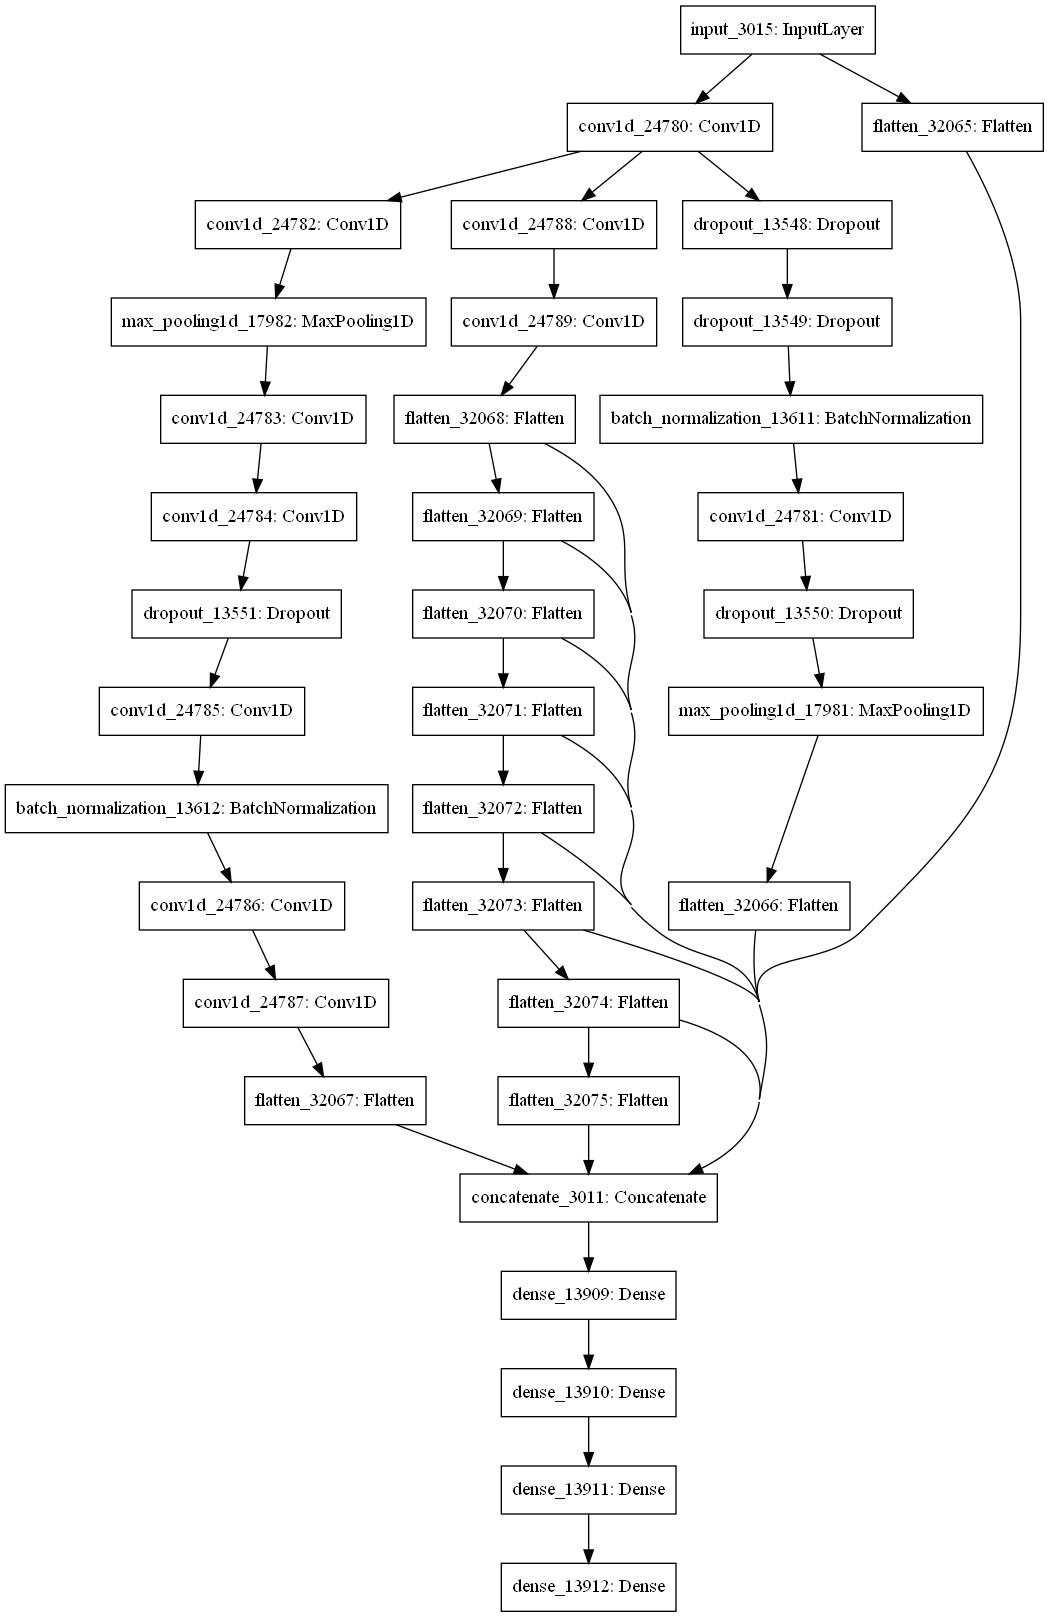

In [ ]:
# import pydot
# pydot.find_graphviz()
plot_model(model)


In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=30, 
                    validation_data=testDataGen)

Epoch 1/30
37/37 [==============================] - 2s 26ms/step - loss: 0.0959 - val_loss: 0.0580
Epoch 2/30
37/37 [==============================] - 1s 18ms/step - loss: 0.0197 - val_loss: 0.0299
Epoch 3/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0114 - val_loss: 0.0053
Epoch 4/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 5/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 6/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 7/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0078 - val_loss: 0.0158
Epoch 8/30
37/37 [==============================] - 1s 18ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 9/30
37/37 [==============================] - 1s 18ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 10/30
37/37 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 11/

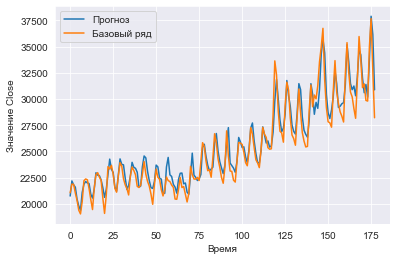

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные
 
# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

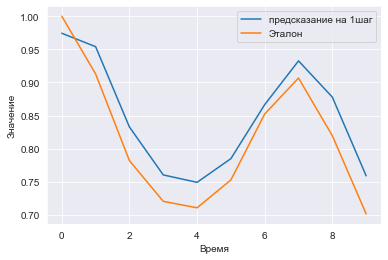

([0.9742973422146791,
  0.9540197874422645,
  0.8326367452489966,
  0.7602157247316569,
  0.7489940948798618,
  0.7847916887480688,
  0.8664597289730067,
  0.9325456374118745,
  0.8777867671176979,
  0.758849980724923],
 [1.0000000000000042,
  0.9128586787071123,
  0.78180127149409,
  0.7202988869131627,
  0.7105186078623946,
  0.7525903199684922,
  0.8522596793815091,
  0.9065995595190239,
  0.8194556089631903,
  0.7012729374860172])

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)

In [ ]:
model.save('Documents/ДЗ/29/model_fin.h5')

В итоге ГА подорабала модель, чья mse меньше в два раза чем предыдущие значения - 0.0021. Данное улучшение заметно и на графике предсказания. 